Preparing models for 2 different approaches: tree models and neural networks.
Can bring in the latter after forming some initial hypotheses about how samples are clustered.

Input Data Files:
in ./input_data_files/
- 18Sv4 and 18Sv9 asv counts, raw counts
- 18Sv4 and 18Sv8 asv counts, CPL counts
- exclude_samples.txt, samples to filter out of analysis
- new 18Sv4 and 18Sv9 taxonomies on pr2 5.0.0

No longer importing MFT databases, helper method "identify_mixo_by_taxo" does that now.

outputs of this notebook:
- see if we need any. may be that CPL proportions, or MFT_loose proportions, *or both*, offer no improvement over strict species-match ASV classification & rawcounts per-sample proportions.

### **Reading in input files**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#any functions required by other notebooks have been moved here
#reimport when changing functions
from helper_functions import proportional_frequencies, shannon_index, asv_richness, identify_mixo_by_taxo

In [3]:
raw_asv_counts_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S.tsv", sep = "\t", index_col = 0)
raw_asv_counts_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax.tsv", sep = "\t", index_col = 0)

raw_asv_cpl_18Sv9 = pd.read_csv("input_data_files/NCOG_18sV9_asv_count_tax_S_cpl.tsv", sep = "\t", index_col = 0)
raw_asv_cpl_18Sv4 = pd.read_csv("input_data_files/NCOG_18sV4_asv_count_tax_S_cpl.tsv", sep = "\t", index_col = 0)

raw_asv_taxonomies_18Sv9 = pd.read_csv("input_data_files/18Sv9_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)
raw_asv_taxonomies_18Sv4 = pd.read_csv("input_data_files/18Sv4_pr2_5.0.0_classifications.tsv", sep = "\t", index_col = 0)

samples_to_exclude = pd.read_csv("input_data_files/exclude_samples.txt", skiprows=2)
sample_metadata = pd.read_csv("input_data_files/NCOG_sample_log_DNA_stvx_meta_2014-2020.csv", index_col = 0)

In [4]:
#no corresponding "_S" file, including same number of ASVs[?] but more samples
#that's right, the CPL files only include 2014-2016. But they also include more ASVs?
raw_asv_counts_18Sv4.shape,\
raw_asv_cpl_18Sv4.shape

((34498, 1203), (42032, 808))

In [5]:
#making sure all column (sample) indices are unique - they are. diff # of ASVs and samples in each.
raw_asv_counts_18Sv9.shape,\
raw_asv_cpl_18Sv9.shape

((50408, 1542), (50408, 808))

### **Filter out asv counts and rescale to proportions after removing S. pombe**

Can S. pombe be selected from CPL tables?

In [28]:
def sample_select(column):
    """Selects only the columns which correspond to valid sample IDs, and which are not to be excluded,
    and which do not contain only zeroes."""
    return column.name[0] == "X" \
        and column.name[1:7].isdigit() \
        and column.name not in samples_to_exclude \
        and sum(column) > 0

#18Sv4 and v9 do not have the same number of observations (samples).
sample_mask_18Sv4_counts = raw_asv_counts_18Sv4.apply(sample_select, axis = 0)
sample_mask_18Sv9_counts = raw_asv_counts_18Sv9.apply(sample_select, axis = 0)
sample_mask_18Sv4_cpl = raw_asv_cpl_18Sv4.apply(sample_select, axis = 0)
sample_mask_18Sv9_cpl = raw_asv_cpl_18Sv9.apply(sample_select, axis = 0)

#exclude all ASVs identified as internal standard Schizosaccharomyces pomb
non_spike_asvs_18Sv4 = raw_asv_taxonomies_18Sv4.loc[
    raw_asv_taxonomies_18Sv4["Taxon"].str.contains("pombe").apply(lambda x: not x)
].index
non_spike_asvs_18Sv9 = raw_asv_taxonomies_18Sv9.loc[
    raw_asv_taxonomies_18Sv9["Taxon"].str.contains("pombe").apply(lambda x: not x)
].index

In [30]:
#step 1: exclude spikes and rescale to proportions 
asv_proportions_rawcounts_18Sv4 = raw_asv_counts_18Sv4.loc[non_spike_asvs_18Sv4, sample_mask_18Sv4_counts].apply(
    proportional_frequencies, axis = 0
)
asv_proportions_rawcounts_18Sv9 = raw_asv_counts_18Sv9.loc[non_spike_asvs_18Sv9, sample_mask_18Sv9_counts].apply(
    proportional_frequencies, axis = 0
)

In [35]:
raw_asv_cpl_18Sv4.index.size,\
raw_asv_cpl_18Sv4.index.unique().size,\
raw_asv_taxonomies_18Sv4.index.size

(42032, 42032, 34498)

In [31]:
#this has the side effect of dropping all the "extra" ASVs from raw_asv_cpl_18Sv4, but they're not included in the master
#dna_sequences fasta file anyways.
asv_proportions_cpl_18Sv4 = raw_asv_cpl_18Sv4.loc[non_spike_asvs_18Sv4, sample_mask_18Sv4_cpl].apply(
    proportional_frequencies, axis = 0
)
asv_proportions_cpl_18Sv9 = raw_asv_cpl_18Sv9.loc[non_spike_asvs_18Sv9, sample_mask_18Sv9_cpl].apply(
    proportional_frequencies, axis = 0
)

In [37]:
asv_taxo_mft_18Sv4 = raw_asv_taxonomies_18Sv4.loc[asv_proportions_cpl_18Sv4.index]
asv_taxo_mft_18Sv9 = raw_asv_taxonomies_18Sv9.loc[asv_proportions_cpl_18Sv9.index]
asv_taxo_mft_18Sv4["most_specific_name"] = asv_taxo_mft_18Sv4["Taxon"].apply(lambda x: x.strip(";.").split(";")[-1])
asv_taxo_mft_18Sv9["most_specific_name"] = asv_taxo_mft_18Sv9["Taxon"].apply(lambda x: x.strip(";.").split(";")[-1])

In [55]:
asv_taxo_mft_18Sv4["MFT_loose"] = identify_mixo_by_taxo(asv_taxo_mft_18Sv4["most_specific_name"],
                                                        match_by_genus=True, threshold = 10)
asv_taxo_mft_18Sv4["MFT_strict"] = identify_mixo_by_taxo(asv_taxo_mft_18Sv4["most_specific_name"],
                                                        match_by_genus=False)
sum(asv_taxo_mft_18Sv4["MFT_loose"] != ""),\
sum(asv_taxo_mft_18Sv4["MFT_strict"] != "")

(945, 585)

In [73]:
asv_taxo_mft_18Sv9["MFT_loose"] = identify_mixo_by_taxo(asv_taxo_mft_18Sv9["most_specific_name"],
                                                        match_by_genus=True, threshold = 10)
asv_taxo_mft_18Sv9["MFT_strict"] = identify_mixo_by_taxo(asv_taxo_mft_18Sv9["most_specific_name"],
                                                        match_by_genus=False)
sum(asv_taxo_mft_18Sv9["MFT_loose"] != ""),\
sum(asv_taxo_mft_18Sv9["MFT_strict"] != "")

(989, 631)

In [76]:
loose_CM_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[asv_taxo_mft_18Sv4["MFT_loose"] == "CM"].index
strict_CM_asvs_18Sv4 = asv_taxo_mft_18Sv4.loc[asv_taxo_mft_18Sv4["MFT_strict"] == "CM"].index
loose_CM_proportions_cpl_18Sv4 = asv_proportions_cpl_18Sv4.loc[loose_CM_asvs_18Sv4].apply(sum, axis = 0)
strict_CM_proportions_cpl_18Sv4 = asv_proportions_cpl_18Sv4.loc[strict_CM_asvs_18Sv4].apply(sum, axis = 0)
loose_CM_proportions_rawcounts_18Sv4 = asv_proportions_rawcounts_18Sv4.loc[loose_CM_asvs_18Sv4].apply(sum, axis = 0)
strict_CM_proportions_rawcounts_18Sv4 = asv_proportions_rawcounts_18Sv4.loc[strict_CM_asvs_18Sv4].apply(sum, axis = 0)

loose_CM_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[asv_taxo_mft_18Sv9["MFT_loose"] == "CM"].index
strict_CM_asvs_18Sv9 = asv_taxo_mft_18Sv9.loc[asv_taxo_mft_18Sv9["MFT_strict"] == "CM"].index
loose_CM_proportions_cpl_18Sv9 = asv_proportions_cpl_18Sv9.loc[loose_CM_asvs_18Sv9].apply(sum, axis = 0)
strict_CM_proportions_cpl_18Sv9 = asv_proportions_cpl_18Sv9.loc[strict_CM_asvs_18Sv9].apply(sum, axis = 0)
loose_CM_proportions_rawcounts_18Sv9 = asv_proportions_rawcounts_18Sv9.loc[loose_CM_asvs_18Sv9].apply(sum, axis = 0)
strict_CM_proportions_rawcounts_18Sv9 = asv_proportions_rawcounts_18Sv9.loc[strict_CM_asvs_18Sv9].apply(sum, axis = 0)

(array([453., 355., 193.,  79.,  28.,  21.,   9.,   2.,   2.,   3.]),
 array([0.        , 0.00757763, 0.01515527, 0.0227329 , 0.03031054,
        0.03788817, 0.04546581, 0.05304344, 0.06062107, 0.06819871,
        0.07577634]),
 <BarContainer object of 10 artists>)

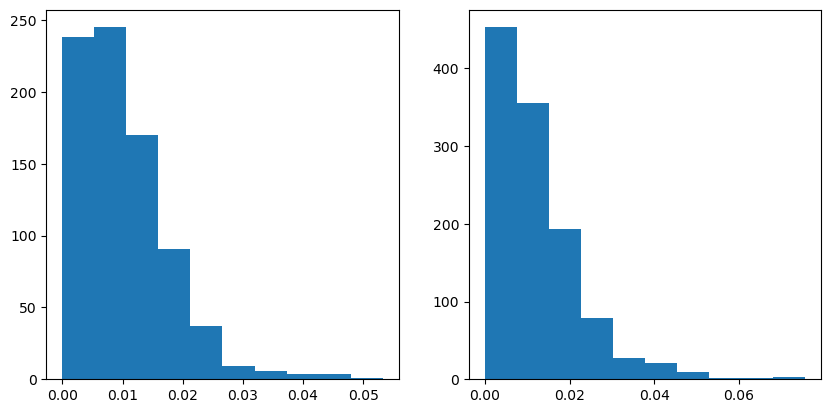

In [68]:
#check if threshold is having intended effect: don't want differences of loose/strict to be too big
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].hist(loose_CM_proportions_cpl_18Sv4 - strict_CM_proportions_cpl_18Sv4)
ax[1].hist(loose_CM_proportions_rawcounts_18Sv4 - strict_CM_proportions_rawcounts_18Sv4)

(array([1.086e+03, 2.700e+01, 9.000e+00, 7.000e+00, 8.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([0.        , 0.04149061, 0.08298123, 0.12447184, 0.16596246,
        0.20745307, 0.24894369, 0.2904343 , 0.33192492, 0.37341553,
        0.41490615]),
 <BarContainer object of 10 artists>)

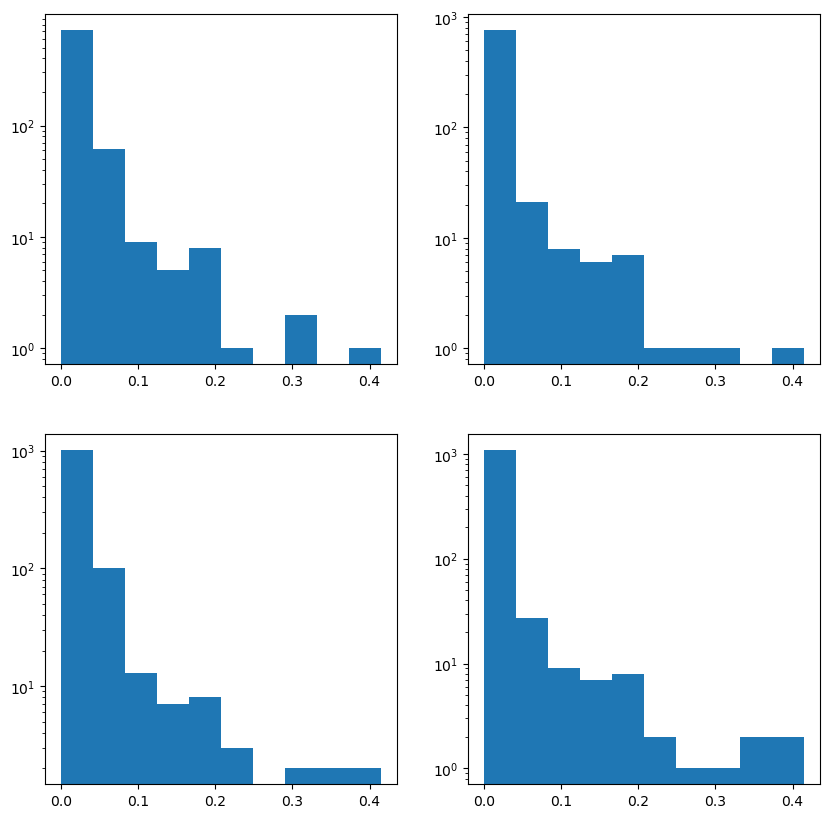

In [71]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
ax[0][0].hist(loose_CM_proportions_cpl_18Sv4, log = True)
ax[0][1].hist(strict_CM_proportions_cpl_18Sv4, log = True)
ax[1][0].hist(loose_CM_proportions_rawcounts_18Sv4, log = True)
ax[1][1].hist(strict_CM_proportions_rawcounts_18Sv4, log = True)

(array([653., 548., 187.,  62.,  16.,  11.,   4.,   2.,   1.,   1.]),
 array([0.        , 0.00480221, 0.00960442, 0.01440664, 0.01920885,
        0.02401106, 0.02881327, 0.03361549, 0.0384177 , 0.04321991,
        0.04802212]),
 <BarContainer object of 10 artists>)

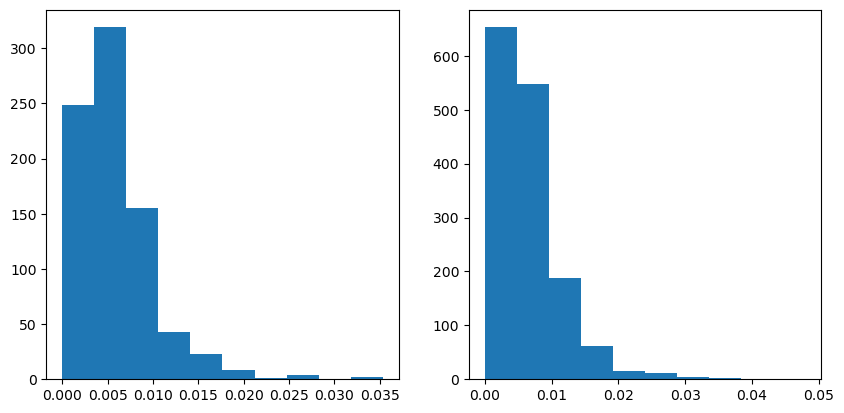

In [77]:
#check if threshold is having intended effect: don't want differences of loose/strict to be too big

fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].hist(loose_CM_proportions_cpl_18Sv9 - strict_CM_proportions_cpl_18Sv9)
ax[1].hist(loose_CM_proportions_rawcounts_18Sv9 - strict_CM_proportions_rawcounts_18Sv9)

(array([1.429e+03, 4.600e+01, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <BarContainer object of 9 artists>)

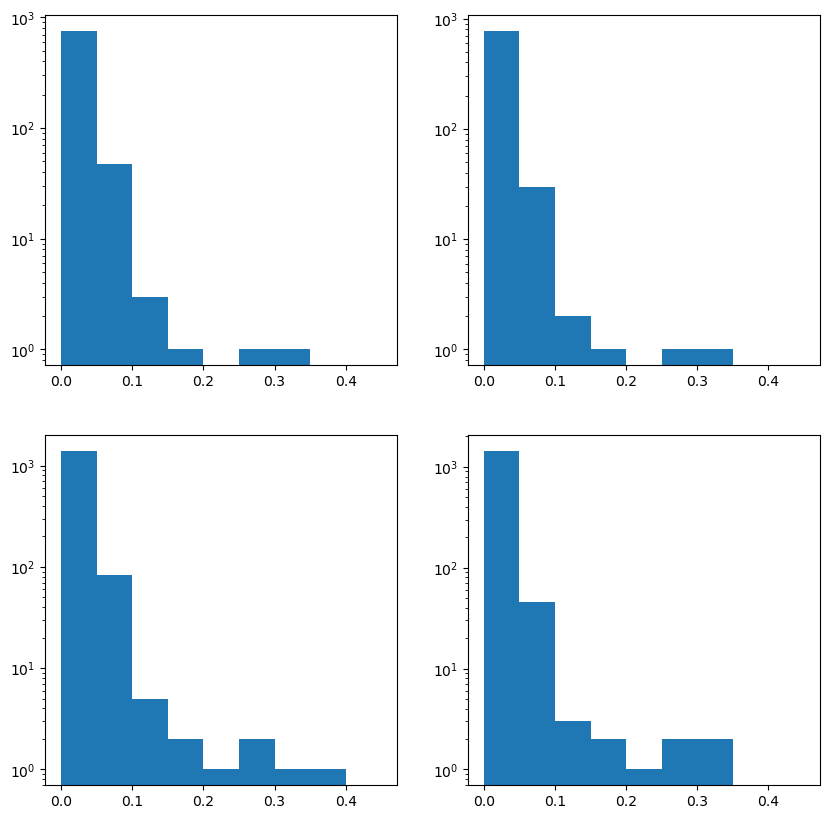

In [79]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
ax[0][0].hist(loose_CM_proportions_cpl_18Sv9, log = True, bins = np.arange(0,0.5,0.05))
ax[0][1].hist(strict_CM_proportions_cpl_18Sv9, log = True, bins = np.arange(0,0.5,0.05))
ax[1][0].hist(loose_CM_proportions_rawcounts_18Sv9, log = True, bins = np.arange(0,0.5,0.05))
ax[1][1].hist(strict_CM_proportions_rawcounts_18Sv9, log = True, bins = np.arange(0,0.5,0.05))

### Conclusion:

**The nonspike CPL proportions and raw counts proportions are not actually that different.** It's single digit (between 10^0 and 10^1) numbers of samples in one bin vs another. Problems with betareg won't go away with this.

MFT selector threshold experiments

In [81]:
asv_taxo_mft_18Sv4.loc[loose_CM_asvs_18Sv4]

,Taxon,Confidence,most_specific_name,MFT_loose,MFT_strict
Feature ID,,,,,
010531ccf5cf2044fa6e8c3542900fe6,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.836344,Fragilidium_duplocampanaeforme,CM,CM
010b0c835e92a111f126a1e760cbe73f,Eukaryota;Haptista;Haptophyta;Haptophyta_X;Pry...,0.996714,Chrysochromulina,CM,
0160d46a0e316439ed3ea98508dce0b3,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,1.000000,Fragilidium_mexicanum,CM,CM
016cd4e18c65f314b8e92525ad03a12c,Eukaryota;Haptista;Haptophyta;Haptophyta_X;Pry...,0.992016,Chrysochromulina_sp,CM,
019c10f67db9022794477232b3eb9586,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,1.000000,Lingulodinium_polyedra,CM,CM
...,...,...,...,...,...
fd2ea1d42f608f9bfba891437786b039,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.926271,Fragilidium_duplocampanaeforme,CM,CM
fdbb0fed47a0912794df87c058eb64d2,Eukaryota;Haptista;Haptophyta;Haptophyta_X;Pry...,0.996878,Chrysochromulina_sp,CM,
fef46c9e7a158a2bb03e518c5888f8aa,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.999998,Lingulodinium_polyedra,CM,CM


In [82]:
asv_taxo_mft_18Sv9.loc[loose_CM_asvs_18Sv9]

,Taxon,Confidence,most_specific_name,MFT_loose,MFT_strict
Feature ID,,,,,
001d7bf29c4f7053d31e8f1fcbeb0b29,Eukaryota:nucl;Cryptista:nucl;Cryptophyta:nucl...,0.880312,Geminigera_cryophila:nucl,CM,CM
00370dd7d21ecfb7f2f2bd38d1993a53,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.930084,Blastodinium,CM,
0065f4344bb905b0fa9ae76e53285e4c,Eukaryota:nucl;Cryptista:nucl;Cryptophyta:nucl...,0.998085,Geminigera_cryophila:nucl,CM,CM
014662e1e3316d2618f4ad77401ba67a,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.968906,Blastodinium,CM,
01bcdb7dcc8eec2ddda3fce720120ed8,Eukaryota;Haptista;Haptophyta;Haptophyta_X;Pry...,0.933052,Chrysochromulina_sp,CM,
...,...,...,...,...,...
fe5aaeda7e2053cdf22c4f9001899548,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.914689,Biecheleria_cincta,CM,CM
fe8fd5880fb24fe18a2c2fadc1ca0d14,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.998613,Pelagodinium_sp,CM,CM
fef5f5659d853209d723691ad31dba24,Eukaryota;TSAR;Alveolata;Dinoflagellata;Dinoph...,0.929477,Bispinodinium_angelaceum,CM,CM
